In [5]:
#@@@@@@@@@@@@@@@@@@@@@@@
#import useful libraries
#@@@@@@@@@@@@@@@@@@@@@@@
import numpy as np

from tqdm import tqdm
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

In [6]:
# loading the boards
state_list = np.loadtxt('board_list.txt').reshape((42188, 6, 6))
state_list = state_list.tolist()

In [7]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#two classes for these two environments
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class battleship:
    '''A class to manage the board'''
    
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def __init__(self, config):
        '''Set up the constructor
            Takes -- config, a dictionary specifying the track dimensions and initial state
        '''
        self.config = config
        self.untouched_board_list = config['boards']
        self.board_list = config['boards']
        self.true_state = np.zeros([config['n'],config['n']])
        self.guesses = np.zeros([config['n'],config['n']])
        self.count_array = np.zeros([config['n'],config['n']])
        self.state = self.generate_state()
        self.previous_count = np.sum(self.count_array)
        self.hits = 0
    
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def generate_state(self):
        """
        This currently takes too long. Not sure how to make it faster. mayber just adding the boards against the final count.
        But how would I toss out boards? 
        """
        final_counts = np.zeros([self.config['n'], self.config['n']])
        index_list = []
        for k in range(len(self.board_list)):
            board = self.board_list[k]
            board = board + self.guesses
            board[board < 0] = 0
            board[board > 1] = 1
            if np.sum(board) != np.sum(self.config['ships']):
                index_list.append(k)
            else:
                final_counts += board
        self.count_array = final_counts
        final_sum = np.sum(final_counts)
        if final_sum != 0:
            log_count = np.log(final_sum)
        else:
            log_count = 0
        rounded = np.round(log_count)
        self.board_list = [item for i, item in enumerate(self.board_list) if i not in index_list]
        return rounded
    

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def position_maker(self,ship):
        '''A function to choose a position for a ship
            Takes:
                self -- class instance info above
                ship -- int, the index in the list of ship lengths
            Returns:
                an int, int pair, the coordinates of the first cell the ship occupies
        '''
        coord_1 = np.random.choice(list(range(self.config['n'] - self.config['ships'][ship] + 1)))    #choose first coordinate, guaranteed to have ship on board
        coord_2 = np.random.choice(list(range(self.config['n'])))    #choose second coordinate
        return coord_1,coord_2

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def check_empty(self,coord_1,coord_2,vert,ship):
        '''A function to make sure the proposed location is currently empty
            Takes:
                self -- class instance info above
                coord_1 -- int, the first coordinate, constrained to ensure the ship lies on the board
                coord_2 -- int, the second coordinate
                vert -- boolean, whether to orient the ship vertically or horizontally
                ship -- int, the index in the list of ship lengths
            Returns:
                a boolean, indicating if the placement is legal
        '''
        if vert:    #if the ship is oriented vertically...
            if sum(self.true_state[coord_1 + list(range(self.config['ships'][ship])),coord_2]) > 0:    #and if there is another ship lying across its path...
                empty = False    #set the empty indicator to false
            else:    #otherwise if the proposed location is empty...
                empty = True    #set the empty indicator to true
        else:    #if the ship is oriented horizontally...
            if sum(self.true_state[coord_2,coord_1 + list(range(self.config['ships'][ship]))]) > 0:    #and if there is anther ship lying across its path...
                empty = False    #set the empty indicator to false
            else:    #otherwise if the proposed location is empty...
                empty = True    #set the empty indicator to true
        return empty

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def place_ship(self,ship):
        '''A function to put a single ship on the board
            Takes:
                self -- class instance info above
                ship -- int, the index in the list of ship lengths
        '''
        empty = False    #init the stopping criterion
        while not empty:    #while we should keep going...
            coord_1,coord_2 = self.position_maker(ship)    #sample a position for the ship
            vert = np.random.uniform() < 0.5    #choose whether ship is horizontal or vertical
            empty = self.check_empty(coord_1,coord_2,vert,ship)    #check if legal
        if vert:    #if the ship is vertical...
            self.true_state[coord_1 + list(range(self.config['ships'][ship])),coord_2] = 1    #place on board
        else:    #if the ship is horizontal...
            self.true_state[coord_2,coord_1 + list(range(self.config['ships'][ship]))] = 1    #place on board
        vert = np.random.uniform() < 0.5    #choose whether ship is horizontal or vertical

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def make_board(self):
        '''A function to put all ships on the board
            Takes:
                self -- class instance info above
        '''
        for j in range(len(self.config['ships'])):    #loop over ship lengths
            self.place_ship(j)    #put on board'
        
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def reset(self):
        '''A function to reset the board
            Takes:
                self -- class instance info above
        '''
        self.true_state = np.zeros([self.config['n'],self.config['n']]) 
        self.guesses = np.zeros([self.config['n'],self.config['n']]) 
        self.board_list = self.untouched_board_list.copy()   #reset the hidden state
        self.make_board()    #place ships again
        self.state = self.generate_state()  #reset the observed state
        self.previous_count = np.sum(self.count_array)
        self.hits = 0

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def check_win(self):
        '''A function to check whether the agent has won
            Takes:
                self -- class instance info above
            Returns:
                a boolean, indicating if the agent sank all the ships
        '''
        if self.hits == sum(self.config['ships']):    #if the number of hits is equal to the total length of ships...
            return True    #return true -- the agent won!
        else:    #otherwise...
            return False    #return false -- the game is still going

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def reward(self,a):
        if self.check_win():
            return 100
        else:
            r = self.previous_count - np.sum(self.count_array)
            self.previous_count = np.sum(self.count_array)
            if self.true_state[a['row'],a['col']] > 0:    #if there is a ship at the chosen location...
                r += 10
            return r
        
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def step(self,a):
        '''A function to update the state given the true enemy fleet locations'''
        if self.true_state[a['row'],a['col']] > 0:    #if there is a ship at the chosen location...
            self.guesses[a['row'],a['col']] = 1    #record a hit on the observed state as a 1
            self.hits += 1
        else:    #if there is no ship
            self.guesses[a['row'],a['col']] = -1    #record a miss on the observed state as a -1
        done = self.check_win()    #check to see if the agent has won
        r = self.reward(a)
        self.state = self.generate_state()
        return{'state':self.state,'reward':r,'done':done}
        

In [8]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#Example usage with random actions
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
config = {'n':6,'ships':[2,3,4], 'boards': []}

n_turns = []

for episode in tqdm(range(1000)):
    board = battleship(config)
    board.make_board()

    update = {'state':[],'reward':1,'done':False}
    count = 0
    while not update['done']:
        a = {'row':np.random.choice(range(config['n']))
                ,'col':np.random.choice(range(config['n']))}
        update = board.step(a = a)
        count += 1
#         print(board.state)
#         time.sleep(0.15)
#         clear_output(wait=True)
    n_turns.append(count)

np.mean(n_turns)


100%|██████████| 1000/1000 [00:01<00:00, 773.59it/s]


np.float64(35.603)

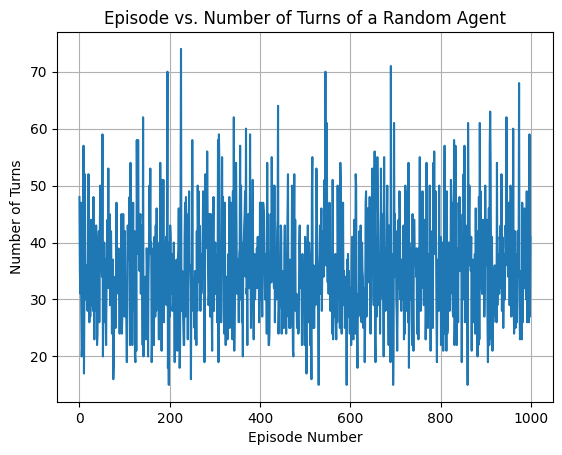

In [9]:
fig, ax = plt.subplots()
ax.plot(range(1000), n_turns)

ax.set(xlabel='Episode Number', ylabel='Number of Turns',
       title='Episode vs. Number of Turns of a Random Agent')
ax.grid()

plt.show()

In [10]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#Finding all possible board combinations
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
config = {'n':6,'ships':[2,3,4], 'boards':[]}

state_list = []

for episode in tqdm(range(100000)):
    board = battleship(config)
    board.make_board()
    board_state = board.true_state
    in_list = False
    for state in state_list:
        if np.array_equal(state, board_state):
            in_list = True
            break
    if not in_list:
        state_list.append(board_state)

print(f'Total boards found: {len(state_list)}')

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [1:07:55<00:00, 24.54it/s]

Total boards found: 42147


In [11]:
with open('board_list.txt', 'w') as outfile:
    outfile.write(f'# Shape: {np.array(state_list).shape}\n')
    for board in state_list:
        np.savetxt(outfile, board)

In [12]:
class Agents:
    def __init__(self, config):
        """
        This method is used to initialize the agent based on the config passed in
        """
        self.gamma = config['gamma']
        self.episodes = config['episodes']
        self.epsilon = config['epsilon']
        self.alpha = config['alpha']
        self.environment = config['environment']
        self.actions = config['A']
        self.Q = {}
        self.threshold = 4

    
    def choose_location(self, state):
        """
        This method uses epsilon greedy in order to pick the best action for a given state.

        Params:
        state - the state of the environment in tuple format
        epsilon - the hyperparameter epsilon that indicates the odds of picking a random action
        Q - The list of values for each state action pair that tells us the probability of selecting a given action

        Returns:
        An action based on the current state of the environment
        """
        flattened = self.environment.count_array.flatten()
        sorted = np.sort(flattened)[::-1]
        top_results = sorted[0:self.threshold]
        top_results[top_results != 0]
        actions = []
        for result in top_results:
            index = np.where(self.environment.count_array == result)
            actions.append((index[0][0],index[1][0]))
        #get list of all q values
        if np.random.uniform() < self.epsilon:
            # pick random action
            selected_action = actions[np.random.choice(range(len(actions)))]
        else:
            #get list of all q values
            q_values = []
            for action in actions:
                if (state, action) not in self.Q.keys():
                        self.Q[(state, action)] = np.random.rand(1)[0]
                q_values.append(self.Q[(state, action)])
            # return the action that gives the highest Q value
            selected_action = actions[np.argmax(q_values)]
        return {'row': selected_action[0], 'col': selected_action[1]}
    
    def SARSA(self, update=True):
        """
        The main method implementing the Monte Carlo algorithm. This uses specifically the Monte Carlo control algorithm with
        soft-epsilon policies.
        """
        self.environment.make_board()
        n_turns = []
        for _ in tqdm(range(self.episodes)):
            # get the state
            state = self.environment.state
            # pick an action
            a = self.choose_location(state)
            a_hashable = (a['row'], a['col'])
            # for each turn...
            done = False
            # while the game is going...
            turns = 0
            while not done:
                # generate r and s'
                stepped_state = self.environment.step(a)
                r = stepped_state['reward']
                s_prime = stepped_state['state']
                done = stepped_state['done']
                # Sample a' according to pi(s')
                a_prime = self.choose_location(s_prime)
                a_prime_hashable = (a['row'], a['col'])
                # Make sure the Q values we need actually exist and if not make them
                if (state, a_hashable) not in self.Q.keys():
                        self.Q[(state, a_hashable)] = np.random.rand(1)[0]
                if (s_prime, a_prime_hashable) not in self.Q.keys():
                        self.Q[(s_prime, a_prime_hashable)] = np.random.rand(1)[0]
                if update:
                    # Update Qpi(s,a) = Qpi(s,a) + alpha[r + gamma * Qpi(s',a') - Qpi(s,a)]        
                    self.Q[(state, a_hashable)] = self.Q[(state, a_hashable)] + self.alpha * (r + self.gamma * self.Q[(s_prime, a_prime_hashable)] - self.Q[(state, a_hashable)])
                # Update s = s' and a = a'
                state  = s_prime
                a = a_prime
                turns += 1
            n_turns.append(turns)
            self.environment.reset()
        return n_turns
    
    def QLearning(self, update=True):
        """
        The main method implementing the Monte Carlo algorithm. This uses specifically the Monte Carlo control algorithm with
        soft-epsilon policies.
        """
        n_turns = []
        for l in tqdm(range(self.episodes)):
            self.environment.make_board()
            # get the state
            state = self.environment.state
            # for each turn...
            done = False
            # while the game is going...
            turns = 0
            while not done:
                # sample a using policy
                a = self.choose_location(state)
                a_hashable = (a['row'], a['col'])
                # generate r and s'
                stepped_state = self.environment.step(a)
                r = stepped_state['reward']
                s_prime = stepped_state['state']
                done = stepped_state['done']
                if update:
                    # Update Qpi(s,a) = Qpi(s,a) + alpha[r + gamma * max(Qpi(s',a')) - Qpi(s,a)]
                    if (state, a_hashable) not in self.Q.keys():
                            self.Q[(state, a_hashable)] = np.random.rand(1)[0]
                    q_values = []
                    for action in self.actions:
                        if (s_prime, action) not in self.Q.keys():
                                self.Q[(s_prime, action)] = np.random.rand(1)[0]
                        q_values.append(self.Q[(s_prime, action)])
                    self.Q[(state,a_hashable)] = self.Q[(state,a_hashable)] + self.alpha*(r + self.gamma*max(q_values) - self.Q[(state,a_hashable)])
                # Update s = s' and a = a'
                state  = s_prime
                turns += 1
            n_turns.append(turns)
            self.environment.reset()
        return n_turns
    
    def Expected_SARSA(self, update=True):
        """
        The main method implementing the Monte Carlo algorithm. This uses specifically the Monte Carlo control algorithm with
        soft-epsilon policies.
        """
        n_turns = []
        for l in tqdm(range(self.episodes)):
            self.environment.make_board()
            # get the state
            state = self.environment.state
            # for each turn...
            done = False
            # while the game is going...
            turns = 0
            while not done:
                # sample a using policy
                a = self.choose_location(state)
                a_hashable = (a['row'], a['col'])
                # generate r and s'
                stepped_state = self.environment.step(a)
                r = stepped_state['reward']
                s_prime = stepped_state['state']
                done = stepped_state['done']
                if update:
                    # Update Qpi(s,a) = Qpi(s,a) + alpha[r + gamma * max(Qpi(s',a')) - Qpi(s,a)]
                    pi = np.full((len(self.actions)), self.epsilon/len(self.actions))
                    q_values = []
                    for action in self.actions:
                        if (state, action) not in self.Q.keys():
                                self.Q[(state, action)] = np.random.rand(1)[0]
                        q_values.append(self.Q[(state, action)])
                    # return the action that gives the highest Q value
                    pi[np.argmax(q_values)] = 1 - self.epsilon + (self.epsilon/len(self.actions))
                    expectation = np.sum(pi * q_values)
                    self.Q[(state,a_hashable)] = self.Q[(state,a_hashable)] + self.alpha*(r + self.gamma * expectation - self.Q[(state,a_hashable)])
                # Update s = s' and a = a'
                state  = s_prime
                turns += 1
            n_turns.append(turns)
            self.environment.reset()
        return n_turns


In [13]:
A = []
for i in range(6):
    for j in range(6):
        A.append((i,j))
gamma = 0.9
episodes = 500
epsilon = 0.1
alpha = 0.1

config = {'n':6,'ships':[2,3,4], 'boards': state_list}
renv = battleship(config)    #set up the environment

agent_config = {'gamma': gamma, 'episodes': episodes, 'epsilon': epsilon, 'environment':renv, 'A':A, 'alpha':alpha}
sarsa_agent = Agents(agent_config)
n_turns_sarsa = sarsa_agent.SARSA()

q_agent = Agents(agent_config)
n_turns_q = q_agent.QLearning()

expected_agent = Agents(agent_config)
n_turns_expected = expected_agent.Expected_SARSA()


100%|██████████| 500/500 [49:56<00:00,  5.99s/it]


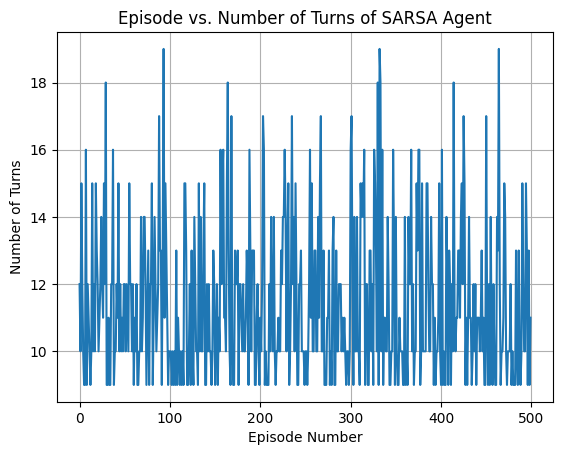

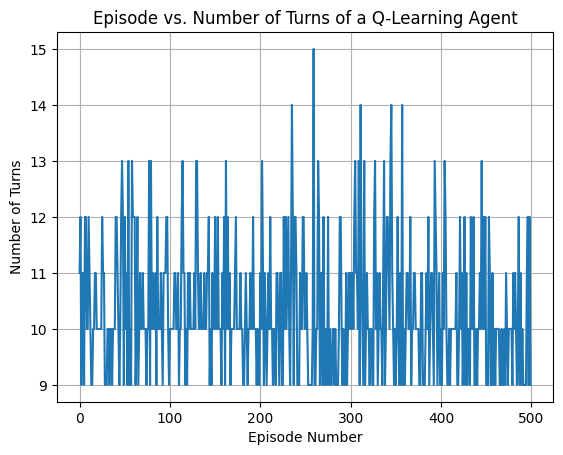

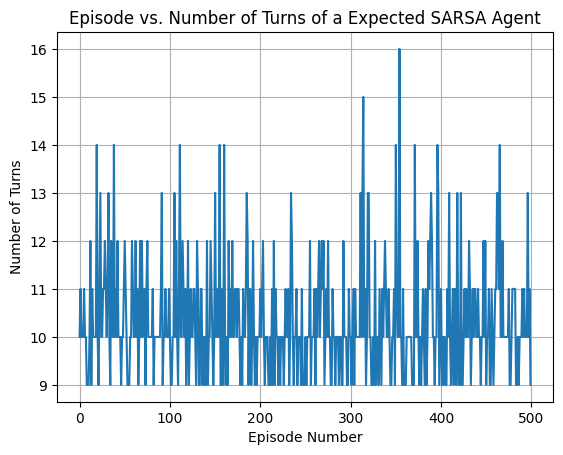

In [14]:
fig, ax = plt.subplots()
ax.plot(range(500), n_turns_sarsa)

ax.set(xlabel='Episode Number', ylabel='Number of Turns',
       title='Episode vs. Number of Turns of SARSA Agent')
ax.grid()

plt.show()

fig, ax = plt.subplots()
ax.plot(range(500), n_turns_q)

ax.set(xlabel='Episode Number', ylabel='Number of Turns',
       title='Episode vs. Number of Turns of a Q-Learning Agent')
ax.grid()

plt.show()

fig, ax = plt.subplots()
ax.plot(range(500), n_turns_expected)

ax.set(xlabel='Episode Number', ylabel='Number of Turns',
       title='Episode vs. Number of Turns of a Expected SARSA Agent')
ax.grid()

plt.show()